<a href="https://colab.research.google.com/github/Sogo95/Detection-de-tweet/blob/main/Tweet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de tweet suspect


Avec l'essor des plateformes sociales, les discours de haine, menaces et intimidations en ligne se sont multipliés, représentant un défi majeur pour la sécurité publique. Identifier ces discours rapidement et efficacement est essentiel pour prévenir les comportements dangereux, tels que le terrorisme ou les menaces. Le machine learning, en particulier les techniques de classification textuelle, offre une solution puissante pour automatiser cette tâche.

Dans ce projet, nous proposons un modèle de machine learning pour classifier les tweets en deux catégories : suspect (menaces, terrorisme, intimidation) et non suspect. Nous utiliserons des techniques modernes de traitement du langage naturel (NLP), incluant le pré-traitement des données textuelles, l'usage d'embeddings pour représenter les tweets, et l'entraînement de plusieurs modèles de classification (Logistic Regression, Random Forest, etc.) afin d'identifier le modèle le plus performant.

# Importation de la base de données

In [ ]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Chargement des données depuis mon compte Drive
df = pd.read_csv('/content/drive/My Drive/NLP2_exo/tweets_suspect.csv')
X = df['message']  # Colonne contenant les tweets
y = df['label']  # Colonne des labels


# Visualisation des classes
Ici l'objectif c'est de voir s'il y' a équilibre entre les classes

In [ ]:
label_distribution = df['label'].value_counts()
print(label_distribution)


label
1    53855
0     6145
Name: count, dtype: int64


Les résultats nous montre qu'il y a un fort déséquilibre entre les classes. En effet:


*   53 855 tweets sont étiquetés comme suspects (label 1)
*   6 145 tweets sont étiquetés comme non suspects (label 0)


Ce qui signifie que les classes sont déséquilibrées, avec environ 90% des données dans la classe "suspect" et 10% dans la classe "non suspect".

Cet écart important et peut affecter les performances des modèles de classification.

Ici, nous proposons comme solution la méthode de Sur-échantillonnage (oversampling) qui va consisté à augmenter la taille de la classe minoritaire (Non Suspect) en utilisant la techniques *SMOTE* (Synthetic Minority Over-sampling Technique).

# Pretraitement des donnees

Dans cette partie, nous allons nettoyer et lemmatiser dles tweets

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
import nltk

#les ressources pour la lemmatisation
nltk.download('wordnet')
nltk.download('punkt')

# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Définition de la fonction de nettoyage et de lemmatisation
def netoy_lemmat(text):
    # Suppression des balises HTML (si jamais présentes dans les tweets)
    text = re.sub(r'<.*?>', '', text)
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text)
    # Suppression des caractères spéciaux
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenisation
    tokens = nltk.word_tokenize(text)
     # Lemmatisation
    lemmatized = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    return ' '.join(lemmatized)


# Application de la fonction de nettoyage sur la colonne 'message'
df['message'] = df['message'].apply(netoy_lemmat)

print(df.head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Traitement terminé.
                                             message  label
0  switchfoot httptwitpiccomyzl awww thats a bumm...      1
1  is upset that he cant update his facebook by t...      1
2  kenichan i dived many time for the ball manage...      1
3       my whole body feel itchy and like it on fire      0
4  nationwideclass no it not behaving at all im m...      1


Embedding (Représentation vectorielles des mots)

Ici, nous allons utilisé le mondèle de DistilBERT qui est un modèle dérivé de BERT, pour faire les représentations vectorielles des tweets. Nous utilisons ici DistilBERT car nous n'avons pas de ressources machine.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def encode_tweet(tweet):
    inputs = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Application de la fonction d'encodage sur la colonne 'message'
df['embedding'] = df['message'].apply(encode_tweet)

print("Embeddings générés.")
print(df['embedding'].head())

Embeddings générés.
0    [0.09697203, 0.0107347835, -0.09857132, -0.077...
1    [-0.07323087, 0.012205904, 0.18167649, -0.0359...
2    [-0.11107304, -0.27665025, -0.0017086323, -0.0...
3    [0.020285048, 0.060706183, 0.006911076, -0.261...
4    [-0.08411519, 0.32839385, 0.042491022, -0.2674...
Name: embedding, dtype: object


# Division des données en ensemble d'entrainement et de test

Nous allons divisé les données en ensemble d'entraînement (80%) et de test (20%). Les embeddings sont stockés dans X, et les labels dans y.

In [ ]:
from sklearn.model_selection import train_test_split

X = df['embedding'].tolist()  # Les embeddings générés
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Entrainement des modèles en appliquant l'Oversampling pour détecter le meilleur modèle

Dans cette partie, nous allons entrainé nos modèle en appliquant la technique de SMOTE, sur nos données afin de sélectionné le meilleur modèle



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Diviser les données
X = df['embedding'].tolist()  # Les embeddings générés
y = df['label']  # Les labels (0 ou 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer le sur-échantillonnage à la classe minoritaire
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normaliser les données (pour la régression logistique)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Créer une liste de modèles à entraîner
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),  # Augmenter max_iter
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour évaluer les performances
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)  # Entraîner le modèle
    y_pred = model.predict(X_test)  # Prédire sur les données de test

    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

# Boucle sur chaque modèle pour l'entraîner et évaluer ses performances
for model_name, model in models.items():
    # Utiliser des données normalisées pour la régression logistique
    X_data = X_train_scaled if model_name == "Logistic Regression" else X_train_resampled
    X_test_data = X_test_scaled if model_name == "Logistic Regression" else X_test

    accuracy, precision, recall, f1 = evaluate_model(model, X_data, y_train_resampled, X_test_data, y_test)

    # Ajouter les résultats à la liste
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convertir la liste des résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher le tableau des résultats
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.774417   0.956556  0.784468  0.862007
1        Random Forest  0.885083   0.910903  0.966599  0.937925
2                  SVM  0.836000   0.942447  0.870570  0.905083
3        Decision Tree  0.728833   0.911058  0.773613  0.836729
4                  KNN  0.359000   0.960322  0.298664  0.455626
5              XGBoost  0.849417   0.925287  0.905456  0.915264


Les résultats de l'entrainement de nos modèle nous montre que: \
Le modèle de Random Forest est le plus performant, avec une accuracy de 88,5% et un excellent recall (96,7%), ce qui signifie qu'il identifie efficacement les classes positives. Son F1-Score de 0.938 montre un bon équilibre entre précision et rappel. Comparativement, XGBoost est également solide mais légèrement inférieur. Les autres modèles, comme Logistic Regression et SVM, sont corrects mais moins efficaces, tandis que KNN est très faible.

En résumé, Random Forest est le meilleur choix pour détecter un discours suspect. La figure ci-dessous illustre cela.

# Visualtion des performance des différents modèle

<ipython-input-18-d21ae3d9d5b4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='F1-Score', palette='viridis')


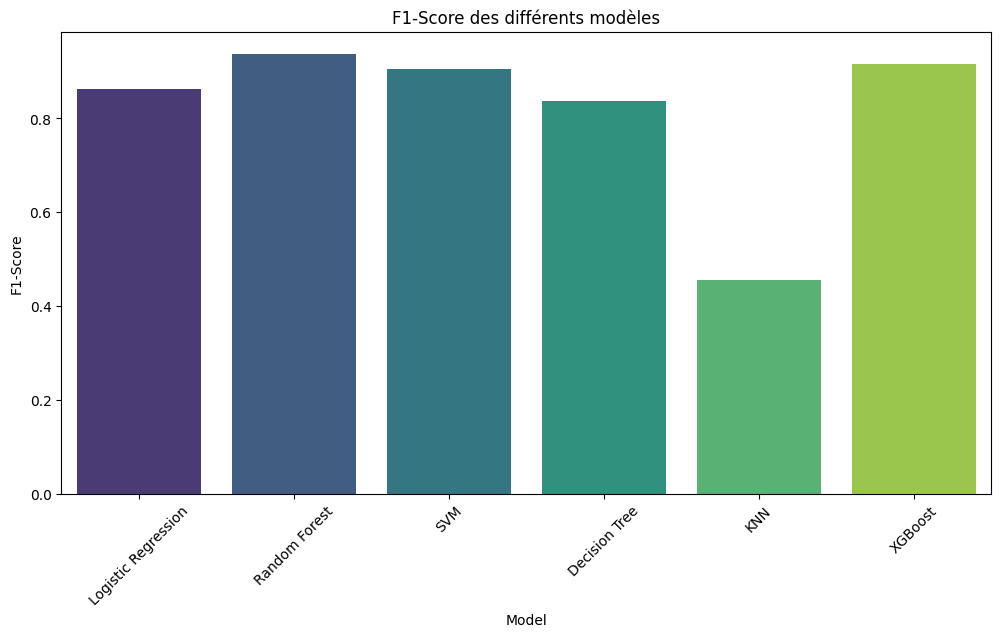

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la taille du graphique
plt.figure(figsize=(12, 6))

# Utiliser seaborn pour un graphique à barres
sns.barplot(data=results_df, x='Model', y='F1-Score', palette='viridis')
plt.title('F1-Score des différents modèles')
plt.ylabel('F1-Score')
plt.show()
